In [2]:
from IPython.display import display
from qiskit import *
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import numpy as np

In [2]:
def myplot(data):
  fig = plot_histogram(data, figsize=(12, 6))
  fig.set_facecolor('white')
  return fig

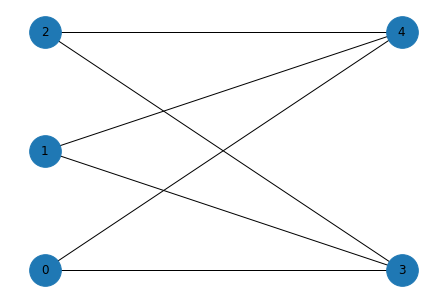

In [3]:
import networkx as nx

G = nx.Graph()
G.add_edges_from([(0,3), (0,4), (1,3), (1,4), (2,3), (2,4)])
nx.draw(G, with_labels=True, node_size=1000, pos=nx.bipartite_layout(G, [0,1,2]))

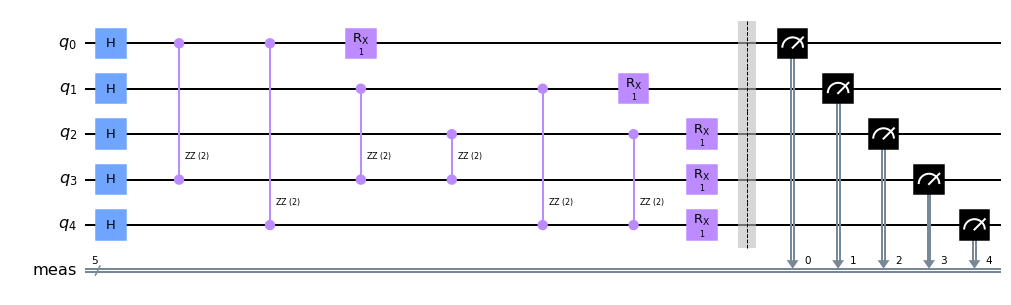

In [4]:
def qaoa(G: nx.Graph, thetas, measure):
  rounds = len(thetas) // 2
  gammas = thetas[:rounds]
  betas = thetas[rounds:]

  n = G.number_of_nodes()
  qc = QuantumCircuit(n)
  qc.h(range(n))
  for i in range(rounds):
    for e in G.edges():
      qc.rzz(2 * gammas[i], e[0], e[1])
    for j in range(n):
      qc.rx(2 * betas[i], j)
  if measure:
    qc.measure_all()
  return qc

qaoa(G, [1, 0.5], True).draw()

In [5]:
def cuts(G: nx.Graph, state: str):
  score = 0
  for i, j in G.edges():
    if state[i] != state[j]:
      score += 1
  return score

def expected_cuts(G: nx.Graph, counts: dict):
  total_cuts = 0
  total_samples = 0
  for state, count in counts.items():
    total_cuts += cuts(G, state) * count
    total_samples += count
  return total_cuts / total_samples

def reverse_stats(stats):
  reversed = {k[::-1]: v for k, v in stats.items()}
  return dict(sorted(reversed.items()))

def sv_to_stats(sv):
  n = int(np.log2(len(sv)))
  return reverse_stats({format(i, f'0{n}b'): np.abs(amp)**2 for (i, amp) in enumerate(sv)})

In [6]:
def f_sampling(G: nx.Graph):
  backend = Aer.get_backend('qasm_simulator')
  def execute(params):
    qc = qaoa(G, params, True)
    counts = reverse_stats(backend.run(qc, seed_simulator=0, num_shots=10000).result().get_counts())
    return -expected_cuts(G, counts)
  return execute

initial = [0.81069872, 2.2067517, 0.83830696, 2.15579759, 0.37060699, 2.42068091, 6.1575306, 2.2453419, 3.85060091, 6.137845]
res = minimize(f_sampling(G), initial, method='COBYLA')
res

     fun: -5.86328125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 126
  status: 1
 success: True
       x: array([1.61884723, 2.1311878 , 0.96225194, 1.93449058, 0.4158964 ,
       2.56259087, 6.13767785, 2.33795955, 4.09036608, 5.96572692])

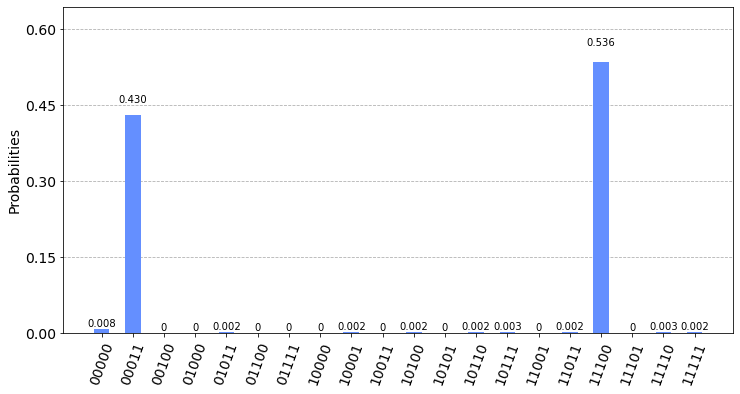

In [7]:
qc = qaoa(G, res.x, True)
backend = Aer.get_backend('qasm_simulator')
counts = reverse_stats(backend.run(qc).result().get_counts())
myplot(counts)

In [8]:
def f_sv(G: nx.Graph):
  backend = Aer.get_backend('statevector_simulator')
  def execute(params):
    qc = qaoa(G, params, False)
    counts = reverse_stats(backend.run(qc).result().get_counts())
    return -expected_cuts(G, counts)
  return execute

initial = [1.0] * (G.number_of_nodes()*2)
res_sv = minimize(f_sv(G), initial, method='COBYLA')
res_sv

     fun: -5.990857943865554
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 368
  status: 1
 success: True
       x: array([1.75578287, 1.08357672, 1.11950429, 2.14525728, 0.6397307 ,
       1.83865605, 0.96298038, 0.81942206, 1.10235353, 1.18187252])

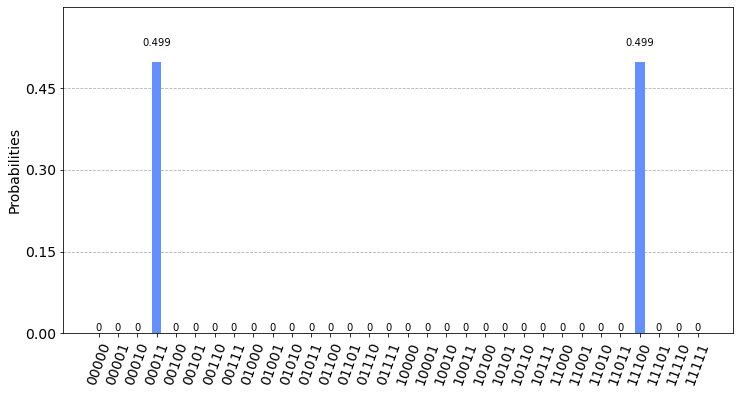

In [9]:
qc = qaoa(G, res_sv.x, False)
backend = Aer.get_backend('statevector_simulator')
sv = backend.run(qc).result().get_statevector()
myplot(sv_to_stats(sv))

In [10]:
from qiskit.algorithms.optimizers import SPSA

spsa = SPSA(maxiter=500)
initial = [1.0] * (G.number_of_nodes()*2)
res_spsa = spsa.optimize(len(initial), f_sampling(G), initial_point=initial)
res_spsa

(array([-1.32375525,  1.17415396,  3.71929642,  2.56212744,  1.73911593,
         2.24463736,  0.25694327,  2.68750458, -0.03539184,  0.27428245]),
 -5.4453125,
 1000)

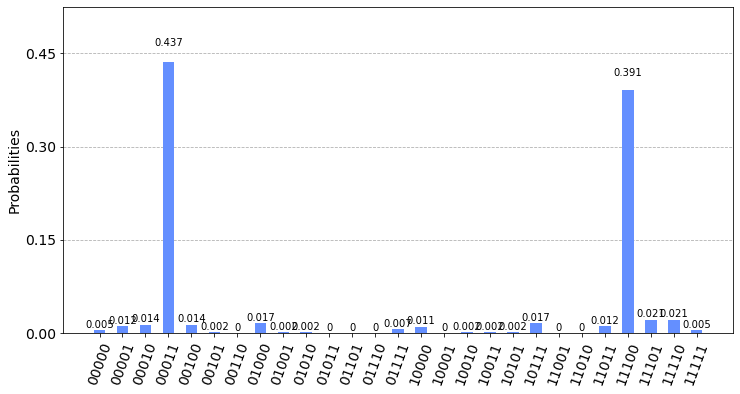

In [11]:
qc = qaoa(G, res_spsa[0], True)
backend = Aer.get_backend('qasm_simulator')
counts = reverse_stats(backend.run(qc).result().get_counts())
myplot(counts)